In [0]:
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.widgets import *
import re

%reload_ext autoreload
%autoreload 2
%matplotlib inline

bs = 64

Будем работать с датасетом "Caltech 101", который содержит в себе 9144 изображения, разделенных на 101 категорию. При загрузке датасета через функцию untar_data() происходит конфликт. Датасет загружается в папку '101_ObjectCategories'. После загрузки датасета данную папку надо переименовать в 'caltech_101' и запустить выполнение кода заново.

In [0]:
dest = '/content/sample_data'
path = untar_data(URLs.CALTECH_101, dest=dest)
path.ls()

[PosixPath('/content/sample_data/caltech_101/dollar_bill'),
 PosixPath('/content/sample_data/caltech_101/emu'),
 PosixPath('/content/sample_data/caltech_101/windsor_chair'),
 PosixPath('/content/sample_data/caltech_101/euphonium'),
 PosixPath('/content/sample_data/caltech_101/dolphin'),
 PosixPath('/content/sample_data/caltech_101/Faces'),
 PosixPath('/content/sample_data/caltech_101/ketch'),
 PosixPath('/content/sample_data/caltech_101/buddha'),
 PosixPath('/content/sample_data/caltech_101/bass'),
 PosixPath('/content/sample_data/caltech_101/brain'),
 PosixPath('/content/sample_data/caltech_101/barrel'),
 PosixPath('/content/sample_data/caltech_101/kangaroo'),
 PosixPath('/content/sample_data/caltech_101/crocodile_head'),
 PosixPath('/content/sample_data/caltech_101/metronome'),
 PosixPath('/content/sample_data/caltech_101/chair'),
 PosixPath('/content/sample_data/caltech_101/dragonfly'),
 PosixPath('/content/sample_data/caltech_101/menorah'),
 PosixPath('/content/sample_data/caltech_

Для последующей классификации изображений создадим список Path объектов каждого изображения.

In [0]:
fnames = []
fnames = [image for name in path.ls() for image in get_image_files(str(name))]
print(f'Всего {len(fnames)} изображений.')

Всего 9144 изображений.


In [0]:
np.random.seed(2)
pat = r'101\/([^\/]+)\/image'

In [0]:
data = ImageDataBunch.from_name_re(path, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

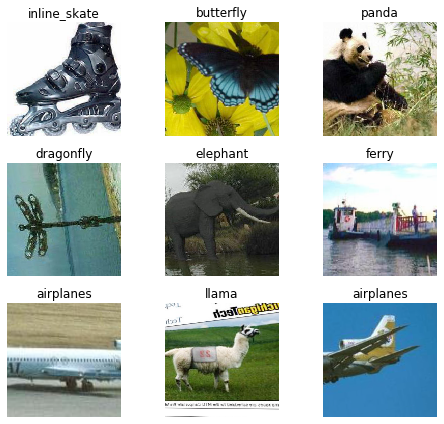

In [0]:
data.show_batch(rows=3, figsize=(7,6))

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 117MB/s] 


In [0]:
learn.model

Обучение модели:

In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.848041,0.482816,0.134026,01:39
1,0.734458,0.359506,0.110503,01:39
2,0.407458,0.285921,0.085886,01:40
3,0.285156,0.273673,0.083151,01:39


In [0]:
learn.save('stage-1')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

Визуализация:

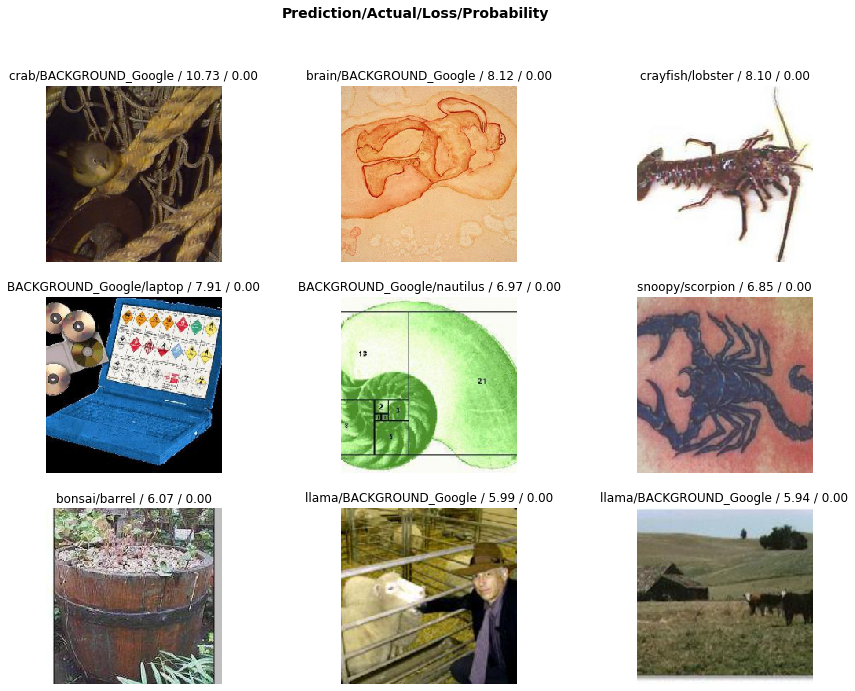

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

In [0]:
interp.most_confused(min_val=2)

[('Faces_easy', 'Faces', 18),
 ('Faces', 'Faces_easy', 5),
 ('helicopter', 'airplanes', 5),
 ('lotus', 'water_lilly', 5),
 ('chair', 'windsor_chair', 4),
 ('crocodile', 'crocodile_head', 4),
 ('crocodile_head', 'crocodile', 4),
 ('ketch', 'schooner', 4),
 ('BACKGROUND_Google', 'garfield', 3),
 ('BACKGROUND_Google', 'joshua_tree', 3),
 ('crayfish', 'scorpion', 3),
 ('lobster', 'crayfish', 3),
 ('schooner', 'ketch', 3),
 ('BACKGROUND_Google', 'llama', 2),
 ('bonsai', 'joshua_tree', 2),
 ('crab', 'crayfish', 2),
 ('electric_guitar', 'mandolin', 2),
 ('elephant', 'brontosaurus', 2),
 ('lobster', 'scorpion', 2),
 ('wrench', 'electric_guitar', 2)]

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.647377,0.352816,0.101751,01:46


In [0]:
learn.load('stage-1')

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


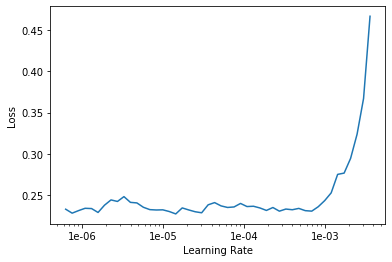

In [0]:
learn.lr_find()  # построим зависимость лосс - скорость обучения
learn.recorder.plot() # визуализируем зависимость

Видно, что где-то после 1e-03 лосс начинает стремительно ухудшаться, поэтому ограничимся диапазоном до 1e-04.

In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.230682,0.251945,0.074398,01:44
1,0.225674,0.248422,0.073851,01:45


Точность улучшилась.

В качестве дополнительного теста модели можно потестировать ее на других изображениях. Экспортируем модель в нашу директорию с изображениями и загрузим ее.


In [0]:
learn.export()

In [0]:
learn = load_learner('/content/sample_data/caltech_101')

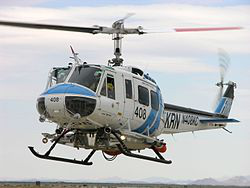

In [0]:
img = open_image('/content/Kfd-205-N408KC-050430-05.jpg')
img

In [0]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category helicopter

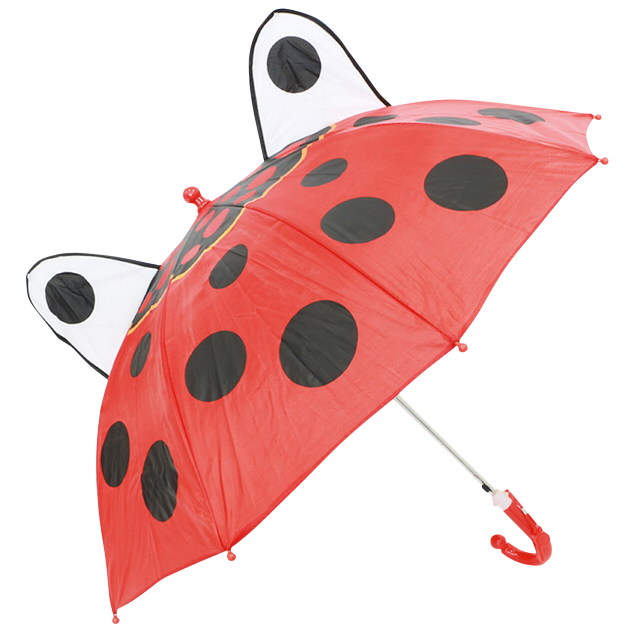

In [0]:
img = open_image('/content/58a5b4e5594bf4fb65df842e7cb4f134.jpg')
img


In [0]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category umbrella